# MANN

In [1]:
# Ignore InterpolationMode warnings from torchmeta
import warnings
warnings.filterwarnings("ignore")

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.optim as optim
import torch.nn.functional as F

from torchmeta.datasets import Omniglot
from torchmeta.transforms import Categorical, ClassSplitter, Rotation
from torchvision.transforms import Compose, Resize, ToTensor, InterpolationMode
from torchmeta.utils.data import BatchMetaDataLoader

In [3]:
seed = 42
np.random.seed(seed);
torch.manual_seed(seed);

## Classes

### `utils.py`

In [4]:
def _convolve(w, s):
    """Circular convolution implementation."""
    assert s.size(0) == 3
    t = torch.cat([w[-1:], w, w[:1]], dim=0)
    c = F.conv1d(t.view(1, 1, -1), s.view(1, 1, -1)).view(-1)
    return c

### `memory.py`

In [5]:
class Memory(nn.Module):
    def __init__(self, memory_size):
        super(Memory, self).__init__()
        self._memory_size = memory_size

        # Initialize memory bias
        initial_state = torch.ones(memory_size) * 1e-6
        self.register_buffer('initial_state', initial_state.data)

        # Initial read vector is a learnt parameter
        self.initial_read = Parameter(torch.randn(1, self._memory_size[1]) * 0.01)

    def get_size(self):
        return self._memory_size

    def reset(self, batch_size):
        self.memory = self.initial_state.clone().repeat(batch_size, 1, 1)

    def get_initial_read(self, batch_size):
        return self.initial_read.clone().repeat(batch_size, 1)

    def read(self):
        return self.memory

    def write(self, w, e, a):
        self.memory = self.memory * (1 - torch.matmul(w.unsqueeze(-1), e.unsqueeze(1)))
        self.memory = self.memory + torch.matmul(w.unsqueeze(-1), a.unsqueeze(1))
        return self.memory

    def size(self):
        return self._memory_size

### `head.py`

In [6]:
class Head(nn.Module):
    def __init__(self, memory, hidden_size):
        super(Head, self).__init__()
        self.memory = memory
        memory_length, memory_vector_length = memory.get_size()
        # (k : vector, beta: scalar, g: scalar, s: vector, gamma: scalar)
        self.k_layer = nn.Linear(hidden_size, memory_vector_length)
        self.beta_layer = nn.Linear(hidden_size, 1)
        self.g_layer = nn.Linear(hidden_size, 1)
        self.s_layer = nn.Linear(hidden_size, 3)
        self.gamma_layer = nn.Linear(hidden_size, 1)
        for layer in [self.k_layer, self.beta_layer, self.g_layer, self.s_layer, self.gamma_layer]:
            nn.init.xavier_uniform_(layer.weight, gain=1.4)
            nn.init.normal_(layer.bias, std=0.01)

        self._initial_state = Parameter(torch.randn(1, self.memory.get_size()[0]) * 1e-5)

    def get_initial_state(self, batch_size):
        # Softmax to ensure weights are normalized
        return F.softmax(self._initial_state, dim=1).repeat(batch_size, 1)

    def get_head_weight(self, x, previous_state, memory_read):
        k = self.k_layer(x)
        beta = F.softplus(self.beta_layer(x))
        g = torch.sigmoid(self.g_layer(x))
        s = F.softmax(self.s_layer(x), dim=1)
        gamma = 1 + F.softplus(self.gamma_layer(x))
        # Focusing by content
        w_c = F.softmax(beta * F.cosine_similarity(memory_read + 1e-16, k.unsqueeze(1) + 1e-16, dim=-1), dim=1)
        # Focusing by location
        w_g = g * w_c + (1 - g) * previous_state
        w_t = self.shift(w_g, s)
        w = w_t ** gamma
        w = torch.div(w, torch.sum(w, dim=1).unsqueeze(1) + 1e-16)
        return w

    def shift(self, w_g, s):
        result = w_g.clone()
        for b in range(len(w_g)):
            result[b] = _convolve(w_g[b], s[b])
        return result

In [7]:
class ReadHead(Head):
    def forward(self, x, previous_state):
        memory_read = self.memory.read()
        w = self.get_head_weight(x, previous_state, memory_read)
        return torch.matmul(w.unsqueeze(1), memory_read).squeeze(1), w

In [8]:
class WriteHead(Head):
    def __init__(self, memory, hidden_size):
        super(WriteHead, self).__init__(memory, hidden_size)
        memory_length, memory_vector_length = memory.get_size()
        self.e_layer = nn.Linear(hidden_size, memory_vector_length)
        self.a_layer = nn.Linear(hidden_size, memory_vector_length)
        for layer in [self.e_layer, self.a_layer]:
            nn.init.xavier_uniform_(layer.weight, gain=1.4)
            nn.init.normal_(layer.bias, std=0.01)

    def forward(self, x, previous_state):
        memory_read = self.memory.read()
        w = self.get_head_weight(x, previous_state, memory_read)
        e = torch.sigmoid(self.e_layer(x))
        a = self.a_layer(x)

        # write to memory (w, memory, e , a)
        self.memory.write(w, e, a)
        return w

### `controller.py`

In [9]:
class Controller(nn.Module):
    def __init__(self, lstm_controller, vector_length, hidden_size):
        super(Controller, self).__init__()
        # We allow either a feed-forward network or a LSTM for the controller
        self._lstm_controller = lstm_controller
        if self._lstm_controller:
            self._controller = LSTMController(vector_length, hidden_size)
        else:
            self._controller = FeedForwardController(vector_length, hidden_size)

    def forward(self, x, state):
        return self._controller(x, state)

    def get_initial_state(self, batch_size):
        return self._controller.get_initial_state(batch_size)

In [10]:
class FeedForwardController(nn.Module):
    def __init__(self, vector_length, hidden_size):
        super(FeedForwardController, self).__init__()
        self.layer_1 = nn.Linear(vector_length, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, hidden_size)
        stdev = 5 / (np.sqrt(vector_length + hidden_size))
        nn.init.uniform_(self.layer_1.weight, -stdev, stdev)
        nn.init.uniform_(self.layer_2.weight, -stdev, stdev)

    def forward(self, x, state):
        x1 = F.relu(self.layer_1(x))
        output = F.relu(self.layer_2(x1))
        return output, state

    def get_initial_state(self):
        return 0, 0

In [11]:
class LSTMController(nn.Module):
    def __init__(self, vector_length, hidden_size):
        super(LSTMController, self).__init__()
        self.layer = nn.LSTM(input_size=vector_length, hidden_size=hidden_size)
        # The hidden state is a learned parameter
        self.lstm_h_state = Parameter(torch.randn(1, 1, hidden_size) * 0.05)
        self.lstm_c_state = Parameter(torch.randn(1, 1, hidden_size) * 0.05)
        for p in self.layer.parameters():
            if p.dim() == 1:
                nn.init.constant_(p, 0)
            else:
                stdev = 5 / (np.sqrt(vector_length + hidden_size))
                nn.init.uniform_(p, -stdev, stdev)

    def forward(self, x, state):
        output, state = self.layer(x.unsqueeze(0), state)
        return output.squeeze(0), state

    def get_initial_state(self, batch_size):
        lstm_h = self.lstm_h_state.clone().repeat(1, batch_size, 1)
        lstm_c = self.lstm_c_state.clone().repeat(1, batch_size, 1)
        return lstm_h, lstm_c

### `ntm.py`

In [12]:
class NTM(nn.Module):
    def __init__(self, vector_length, hidden_size, memory_size, lstm_controller=True):
        super(NTM, self).__init__()
        self.controller = Controller(lstm_controller, vector_length + 1 + memory_size[1], hidden_size)
        self.memory = Memory(memory_size)
        self.read_head = ReadHead(self.memory, hidden_size)
        self.write_head = WriteHead(self.memory, hidden_size)
        self.fc = nn.Linear(hidden_size + memory_size[1], 5)
        nn.init.xavier_uniform_(self.fc.weight, gain=1)
        nn.init.normal_(self.fc.bias, std=0.01)

    def get_initial_state(self, batch_size):
        self.memory.reset(batch_size)
        controller_state = self.controller.get_initial_state(batch_size)
        read = self.memory.get_initial_read(batch_size)
        read_head_state = self.read_head.get_initial_state(batch_size)
        write_head_state = self.write_head.get_initial_state(batch_size)
        return (read, read_head_state, write_head_state, controller_state)

    def forward(self, x, previous_state):
        previous_read, previous_read_head_state, previous_write_head_state, previous_controller_state = previous_state
        controller_input = torch.cat([x, previous_read], dim=1)
        controller_output, controller_state = self.controller(controller_input, previous_controller_state)
        # Read
        read_head_output, read_head_state = self.read_head(controller_output, previous_read_head_state)
        # Write
        write_head_state = self.write_head(controller_output, previous_write_head_state)
        fc_input = torch.cat((controller_output, read_head_output), dim=1)
        state = (read_head_output, read_head_state, write_head_state, controller_state)
        return F.softmax(self.fc(fc_input), dim=1), state

## Hyperparameters

In [13]:
# Number of classes
N_WAY = 5
# Number of images per class
N_SHOT = 5
# Size of a minibatch
BATCH_SIZE = 16

In [14]:
HIDDEN_LAYER_SIZE = 200
MEMORY_SIZE = (128, 40)
USE_LSTM_CONTROLLER = True
N_EPISODES = 300

VECTOR_LENGTH = 20*20 + N_WAY - 1 # TODO: Fix classes to set this properly

## Omniglot

In [15]:
dataset = Omniglot(
    "data",
    num_classes_per_task=N_WAY,
    transform=Compose([Resize(20), ToTensor()]),
    target_transform=Categorical(num_classes=N_WAY),
    class_augmentations=[Rotation([90, 180, 270])],
    meta_train=True,
    download=True,
)
dataset = ClassSplitter(dataset, shuffle=True, num_train_per_class=N_SHOT, num_test_per_class=N_SHOT)
dataloader = BatchMetaDataLoader(dataset, batch_size=BATCH_SIZE, num_workers=4)

In [16]:
def inputs_targets_to_seq(inputs, targets, N_WAY):
    X = inputs.flatten(2, 4)
    y = F.one_hot(targets, num_classes=N_WAY)
    y = torch.cat((torch.zeros(y.shape[0], 1, y.shape[2]), y), dim=1)[:, :-1, :]
    seq = torch.cat((X, y), dim=2)
    seq = torch.swapaxes(seq, 0, 1)

    # Shape: (seq_len, batch, n_features)
    return seq

## Model

In [17]:
model = NTM(VECTOR_LENGTH, HIDDEN_LAYER_SIZE, MEMORY_SIZE, USE_LSTM_CONTROLLER)
optimizer = optim.RMSprop(model.parameters(), momentum=0.9, alpha=0.95, lr=1e-4)

## Loop

In [18]:
def train_one_episode(inputs, targets, optimizer, BATCH_SIZE, N_WAY):
    seq = inputs_targets_to_seq(inputs, targets, N_WAY)

    optimizer.zero_grad()
    state = model.get_initial_state(BATCH_SIZE)
    y_out = torch.zeros((len(seq), BATCH_SIZE, N_WAY))
    for j, vector in enumerate(seq):
        y_out[j], state = model(vector, state)
    loss = F.cross_entropy(y_out.permute(1, 2, 0), targets)
    loss.backward()
    optimizer.step()

    correct = torch.sum(y_out.permute(1, 2, 0).argmax(dim=1) == targets)
    acc = correct.item() / np.prod(train_targets.size())
    
    return loss.item(), acc

In [19]:
def test_one_episode(inputs, targets, BATCH_SIZE, N_WAY):
    seq = inputs_targets_to_seq(inputs, targets, N_WAY)
    state = model.get_initial_state(BATCH_SIZE)
    y_out = torch.zeros((len(seq), BATCH_SIZE, N_WAY))
    for j, vector in enumerate(seq):
        y_out[j], state = model(vector, state)
    loss = F.cross_entropy(y_out.permute(1, 2, 0), targets)
    correct = torch.sum(y_out.permute(1, 2, 0).argmax(dim=1) == targets)
    acc = correct.item() / np.prod(test_targets.size())

    return loss.item(), acc

In [20]:
print("| EPISODE |      TRAIN      |       TEST      |")
print("|         | LOSS   |  ACC   |  LOSS  |  ACC   |")
train_loss_per_ep, train_acc_per_ep = [], []
test_loss_per_ep, test_acc_per_ep = [], []
for episode_i, batch in enumerate(dataloader):
    if episode_i > N_EPISODES: break

    # Train
    train_inputs, train_targets = batch["train"]
    train_loss, train_acc = train_one_episode(train_inputs, train_targets, optimizer, BATCH_SIZE, N_WAY)
    train_loss_per_ep.append(train_loss)
    train_acc_per_ep.append(train_acc)

    # Test
    test_inputs, test_targets = batch["test"]
    test_loss, test_acc = test_one_episode(test_inputs, test_targets, BATCH_SIZE, N_WAY)
    test_loss_per_ep.append(test_loss)
    test_acc_per_ep.append(test_acc)

    if episode_i % 10 == 0:
        print(f"| {episode_i:7d} | {train_loss:.4f} | {train_acc:.4f} | {test_loss:.4f} | {test_acc:.4f} |")

| EPISODE |      TRAIN      |       TEST      |
|         | LOSS   |  ACC   |  LOSS  |  ACC   |
|       0 | 1.6103 | 0.2050 | 1.6085 | 0.2250 |
|      10 | 1.5710 | 0.3950 | 1.5665 | 0.4150 |
|      20 | 1.5187 | 0.5225 | 1.5145 | 0.5050 |
|      30 | 1.4684 | 0.5325 | 1.4486 | 0.5550 |
|      40 | 1.3977 | 0.6200 | 1.3749 | 0.6650 |
|      50 | 1.3295 | 0.7275 | 1.3127 | 0.7200 |
|      60 | 1.2731 | 0.7550 | 1.2719 | 0.7650 |
|      70 | 1.2310 | 0.7725 | 1.2457 | 0.7325 |
|      80 | 1.1999 | 0.7875 | 1.2106 | 0.7825 |
|      90 | 1.1885 | 0.8000 | 1.1841 | 0.7800 |
|     100 | 1.1608 | 0.7900 | 1.1637 | 0.7950 |
|     110 | 1.1322 | 0.8250 | 1.1309 | 0.8075 |
|     120 | 1.1194 | 0.8275 | 1.1100 | 0.8225 |
|     130 | 1.1169 | 0.8325 | 1.1192 | 0.8175 |
|     140 | 1.1179 | 0.8400 | 1.1048 | 0.8325 |
|     150 | 1.0850 | 0.8450 | 1.0833 | 0.8550 |
|     160 | 1.0774 | 0.8425 | 1.0744 | 0.8450 |
|     170 | 1.0837 | 0.8500 | 1.0739 | 0.8500 |
|     180 | 1.0584 | 0.8825 | 1.0620 | 0

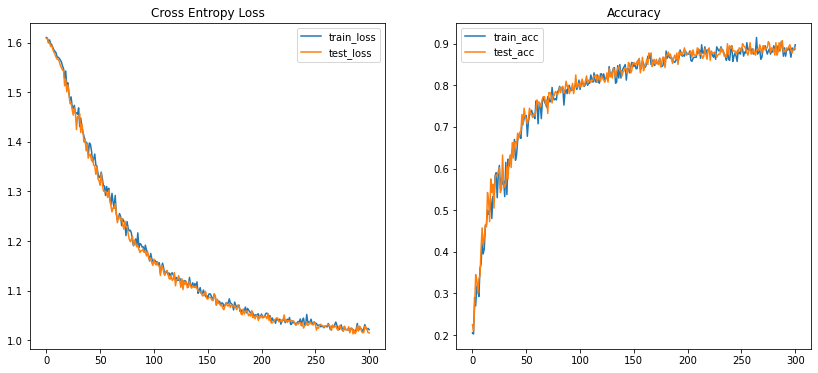

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(train_loss_per_ep, label="train_loss")
axs[0].plot(test_loss_per_ep, label="test_loss")
axs[0].set_title("Cross Entropy Loss")
axs[0].legend()

axs[1].plot(train_acc_per_ep, label="train_acc")
axs[1].plot(test_acc_per_ep, label="test_acc")
axs[1].set_title("Accuracy")
axs[1].legend()

fig.show()